<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Filter-data" data-toc-modified-id="Filter-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Filter data</a></span></li><li><span><a href="#Knn" data-toc-modified-id="Knn-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Knn</a></span><ul class="toc-item"><li><span><a href="#Predicting-based-on-full-info" data-toc-modified-id="Predicting-based-on-full-info-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Predicting based on full info</a></span></li><li><span><a href="#Predicting-iteratively" data-toc-modified-id="Predicting-iteratively-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Predicting iteratively</a></span></li></ul></li><li><span><a href="#Analysis-of-resulting-classifications" data-toc-modified-id="Analysis-of-resulting-classifications-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis of resulting classifications</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-classes-per-classification-technique" data-toc-modified-id="Distribution-of-classes-per-classification-technique-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Distribution of classes per classification technique</a></span></li><li><span><a href="#Transition-tables" data-toc-modified-id="Transition-tables-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Transition tables</a></span></li><li><span><a href="#Comparing-mean-return-per-class-for-the-different-classification-techniques" data-toc-modified-id="Comparing-mean-return-per-class-for-the-different-classification-techniques-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Comparing mean return per class for the different classification techniques</a></span></li></ul></li><li><span><a href="#Evaluating-classification-techniques" data-toc-modified-id="Evaluating-classification-techniques-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluating classification techniques</a></span><ul class="toc-item"><li><span><a href="#MSE-between-each-fund-and-average-style-return" data-toc-modified-id="MSE-between-each-fund-and-average-style-return-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>MSE between each fund and average style return</a></span></li></ul></li><li><span><a href="#Sanity-checks" data-toc-modified-id="Sanity-checks-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Sanity checks</a></span><ul class="toc-item"><li><span><a href="#Analysing-individual-portfolios" data-toc-modified-id="Analysing-individual-portfolios-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Analysing individual portfolios</a></span></li><li><span><a href="#Inspecting-individual-nearest-neighbors" data-toc-modified-id="Inspecting-individual-nearest-neighbors-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Inspecting individual nearest neighbors</a></span></li></ul></li></ul></div>

# Classification

In [71]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler, scale
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.decomposition import TruncatedSVD

# Progress bar
from ipywidgets import FloatProgress
from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Setup

In [174]:
#### Options #####
##################

year             = 2016

style_class      = 'lipper_class' # Choose lipper_class, style_class or cap_class
n_neighbors      = 5              # Number of neighbors to use in k-nn algorithm
perc_rows_used   = 1              # 1: all funds are reclassified once, 2: ... twice, etc.
distance_param   = 2              # 1: manhattan distance, 2: euclidian distance

cols             = ['model_lipper',
                    'model_knn_full',
                    'model_knn_iterative'] # Do not change, only names

## Load Data

In [175]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

## Filter data 

In [176]:
# Now filter everything
#######################
row_info_f = row_info.query('year == @year')

begin_date = row_info_f.iloc[0,:]['report_dt']
end_date = begin_date + pd.DateOffset(years=1,months=1,days = 5)
row_info_f.reset_index(drop = True, inplace=True)

# Filter returns
crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
returns_f = returns.copy()
query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
returns_f = returns_f.query(query)

# Change return of month for which holdings apply to 0
mask = returns_f['report_dt'] == begin_date
returns_f.loc[mask,'mret'] = 0

# Filter holdings accordingly and delet all empty columns
holdings_f = holdings[row_info_f['row']]
col_sums = pd.DataFrame(holdings_f.sum(0).T).values 
mask = (col_sums != 0).flatten()
holdings_f = holdings_f[:,mask]

print('Shape of row_info:')
print(row_info_f.shape)
print('Shape of holdings:')
print(holdings_f.shape)
print('Shape of returns:')
print(returns_f.shape)
print('Report_dt:')
print(begin_date)
print(end_date)

Shape of row_info:
(1922, 9)
Shape of holdings:
(1922, 5586)
Shape of returns:
(26165, 7)
Report_dt:
2016-09-30 00:00:00
2017-11-04 00:00:00


## Knn 

### Predicting based on full info

In [177]:
X = holdings_f
y = list(row_info_f[style_class].values)

y_df = pd.Series(y)

style_df = pd.DataFrame({
    'model_lipper' : y})

print('Dimensions match:       {}'.format(X.shape[0] == len(y)))

np.random.seed(0)

neigh_full = KNeighborsClassifier(
                        n_neighbors = n_neighbors,
                        p = distance_param,
                        n_jobs = -1)

neigh_full.fit(X,y) 

X = holdings_f
y = list(row_info_f[style_class].values)

y_df = pd.Series(y)

style_df = pd.DataFrame({
    'model_lipper' : y})

print('Dimensions match:       {}'.format(X.shape[0] == len(y)))

style_df.loc[:,'model_knn_full'] = neigh_full.predict(X)

Dimensions match:       True
Dimensions match:       True


### Predicting iteratively

In [194]:
%%time

#### Algo ####

np.random.seed(0)
n_rows = X.shape[0]
chosen_indices = []

# Setup of index for choosing rows iteratively
index = np.arange(n_rows)
np.random.shuffle(index)
index = np.concatenate((index,index,index,index,index))
n_rows_chosen = round(n_rows * perc_rows_used)
index = index[:n_rows_chosen]

it = iter(index)
index = zip(it, it)
i = next(index)

# Setup
f = FloatProgress(min=0, max=n_rows_chosen)

style_df['model_knn_iterative'] = style_df['model_lipper']

# Loop over n_iterations, choose one observation randomly, predict label, save and repeat
print('Progress:')
display(f)

for i in index:
    mask = np.arange(X.shape[0]) # mask for whole sample
    mask_is = ~np.isin(mask,i)   # mask to choose all in sample observations
    mask_oos = np.isin(mask,i)   # mask to choose the x out of sample observations for which we predict

    chosen_indices.append(i)

    # Mask X and labels to exclude row for which prediction will be made
    X_sub = X[mask_is]
    y_df_sub = style_df.loc[mask_is,'model_knn_iterative'].values.tolist()

    # Fit knn model on all but randomly chosen row
    neigh = KNeighborsClassifier(n_neighbors = n_neighbors, p = distance_param, n_jobs = -1)
    neigh.fit(X_sub,y_df_sub) 

    # Predict and save label for randomly chosen row
    style_df.loc[mask_oos,'model_knn_iterative'] = neigh.predict(X[mask_oos])
    
    f.value += 3

row_chosen = np.unique(np.array(chosen_indices).flatten()).shape[0]
print('Rows randomly chosen:    {:4.2f}%'.format(row_chosen / X.shape[0] * 100))
print('Done')

Progress:


FloatProgress(value=0.0, max=1922.0)

Rows randomly chosen:    99.69%
Done
CPU times: user 9.5 s, sys: 2.22 s, total: 11.7 s
Wall time: 54.1 s


## Analysis of resulting classifications

### Distribution of classes per classification technique

Overlap between Lipper class and: 

Knn full prediction:         67.59%
Knn iterative prediction:    52.97%


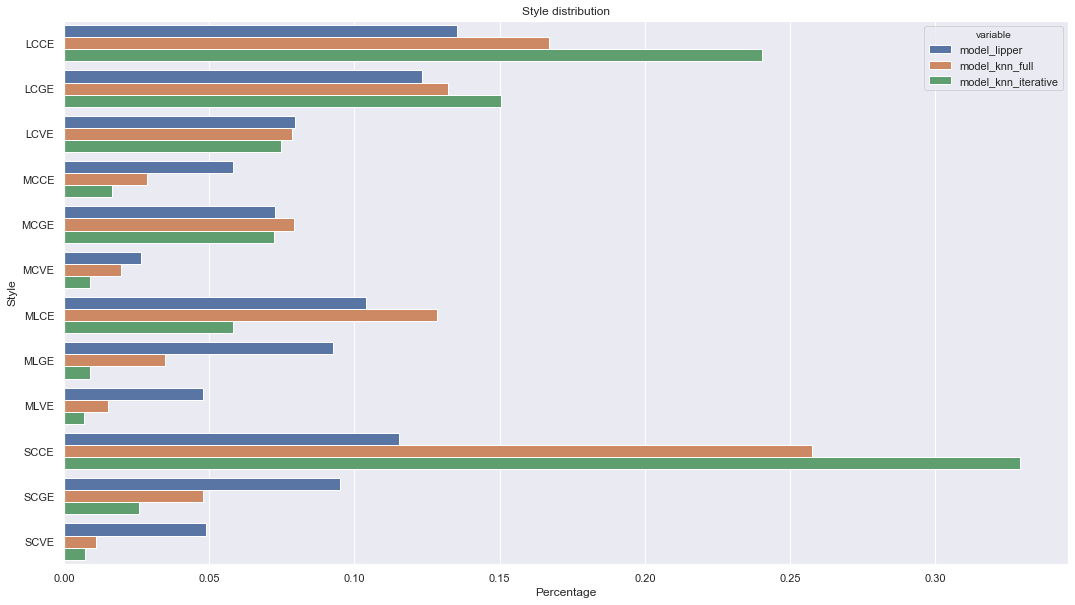

In [198]:
print('Overlap between Lipper class and: \n')
print('Knn full prediction:         {:2.2f}%'
      .format(np.sum(style_df['model_lipper'] == style_df['model_knn_full']) / len(style_df.index) * 100))
print('Knn iterative prediction:    {:2.2f}%'
      .format(np.sum(style_df['model_lipper'] == style_df['model_knn_iterative']) / len(style_df.index) * 100))

data = style_df.apply(pd.Series.value_counts, normalize = True)
data = data.assign(style = data.index)
data = data.melt(id_vars = 'style', value_vars = data.columns[:-1])

sns.set()
plt.figure(figsize=(18,10))
g = sns.barplot(data = data, y = 'style', x = 'value', hue = 'variable')

plt.title('Style distribution')
plt.ylabel('Style')
plt.xlabel('Percentage')

plt.show()

### Transition tables

In [199]:
round(pd.crosstab(style_df['model_lipper'], style_df['model_knn_iterative'], margins=True, normalize='all') * 100,2)

model_knn_iterative,LCCE,LCGE,LCVE,MCCE,MCGE,MCVE,MLCE,MLGE,MLVE,SCCE,SCGE,SCVE,All
model_lipper,,,,,,,,,,,,,
LCCE,11.86,0.26,0.52,0.05,0.00,0.00,0.78,0.00,0.00,0.05,0.00,0.00,13.53
LCGE,1.40,10.61,0.00,0.00,0.00,0.00,0.21,0.10,0.00,0.00,0.00,0.00,12.33
LCVE,2.24,0.00,5.57,0.00,0.00,0.00,0.10,0.00,0.00,0.05,0.00,0.00,7.96
MCCE,0.21,0.00,0.00,0.94,0.31,0.16,0.21,0.00,0.00,4.01,0.00,0.00,5.83
MCGE,0.16,0.00,0.00,0.16,4.94,0.00,0.05,0.05,0.00,1.77,0.16,0.00,7.28
MCVE,0.00,0.00,0.00,0.16,0.00,0.62,0.05,0.00,0.00,1.72,0.00,0.10,2.65
MLCE,5.41,0.10,0.16,0.31,0.16,0.05,2.60,0.00,0.05,1.56,0.00,0.00,10.41
MLGE,1.20,4.01,0.00,0.05,1.77,0.00,0.94,0.73,0.00,0.52,0.05,0.00,9.26
MLVE,1.46,0.05,1.25,0.00,0.00,0.05,0.57,0.00,0.62,0.78,0.00,0.00,4.79


### Comparing mean return per class for the different classification techniques

In [200]:
row_info_m = row_info_f.copy()
returns_m = returns_f.copy()

# concat predicted styles to row_info
row_info_m = pd.concat([row_info_m,style_df],axis = 1)

# merge predicted styles onto returns
returns_m = returns_m.merge(row_info_m[[
                                        'crsp_fundno', 'report_dt', 'model_lipper', 'model_knn_full',
                                        'model_knn_iterative'
                                    ]],
                                   how='left',
                                   on=['crsp_fundno', 'report_dt'])

# melt the different style columns per model into one (from wide to long)
returns_m = pd.melt(returns_m,
                           id_vars=['crsp_fundno', 'report_dt', 'mret'],
                           value_vars=cols,
                           var_name='model',
                           value_name='style')

# Fill all styles and drop nas

temp = (returns_m
            .groupby(['model','crsp_fundno'])
            .apply(lambda x: x.fillna(method = 'ffill'))
)

returns_m['style'] = temp['style']
returns_m = returns_m.dropna()

# Calc mean return per style
style_return = (returns_m
                    .groupby(['model','style','report_dt'])
                    .mean()
                    .reset_index()
                    .drop(columns='crsp_fundno')
)

# Calc cumret per style
style_return['cum_ret'] = (style_return
                                .assign(cum_ret = lambda x: x.mret + 1)
                                .groupby(['model','style'])
                                .apply(lambda x: x['cum_ret'].cumprod())
                                .reset_index()
                                ['cum_ret']
)

# Merge style returns onto fund returns and calc tracking error
returns_m = (returns_m
               .rename(columns = {'mret' : 'fund_ret'}) 
               .merge(style_return,
                            how ='left',
                            on = ['model','style','report_dt'])
                .assign(error = lambda df: df['fund_ret'] - df['mret'])
                .rename(columns = {'mret' : 'style_ret',
                                   'cum_ret' : 'style_cum'}) 
)

returns_m = returns_m[['crsp_fundno', 'report_dt', 'model', 'style',
                       'fund_ret', 'style_ret', 'style_cum', 'error']]

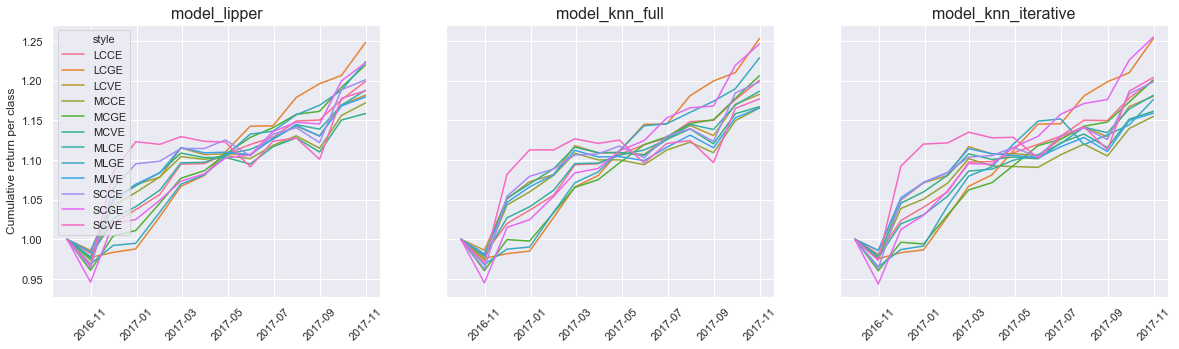

In [201]:
fig, ax = plt.subplots(figsize=(20,5),ncols=3, sharey='row')
for i, col in enumerate(cols):
    sns.lineplot(data = style_return.query(''' model == @col '''),
                 x='report_dt', y='cum_ret', hue='style', ax=ax[i])

# Subplot titles
title = cols
ax[0].set_ylabel('Cumulative return per class')

for i in range(0,3):
    ax[i].set_title(title[i], fontsize = 16)
    ax[i].set_xlabel('')
    for label in ax[i].get_xticklabels():
        label.set_rotation(45)
        
for i in range(1,3):
    ax[i].get_legend().remove()

plt.show()

## Evaluating classification techniques

### MSE between each fund and average style return

In [202]:
error_vol = (returns_m
                 .groupby(['crsp_fundno','model'])['error']
                 .std()
                 .reset_index())

error_vol['error'] = error_vol['error'] * 100

In [203]:
error_vol.groupby('model')['error'].describe()


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
model_knn_full,1901.0,1.102705,1.203691,0.004496,0.651765,0.916095,1.283490,27.556112
model_knn_iterative,1901.0,1.154426,1.198588,0.035049,0.677125,0.958630,1.373598,27.344593
model_lipper,1901.0,1.036918,1.186376,0.070480,0.639031,0.868994,1.180546,27.586490


In [204]:
temp = (error_vol
            .groupby('model')[['error']]
            .apply(lambda x : x.quantile(np.round(np.arange(0.1,1,0.1),2)))
            .reset_index()
            .pivot(columns='level_1',values='error',index='model'))
round(temp,4)

level_1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
model,,,,,,,,,
model_knn_full,0.5072,0.6132,0.7099,0.8080,0.9161,1.0424,1.1846,1.3934,1.7649
model_knn_iterative,0.5090,0.6124,0.7292,0.8440,0.9586,1.1090,1.2677,1.4909,1.9229
model_lipper,0.5011,0.5986,0.6860,0.7807,0.8690,0.9774,1.1092,1.2575,1.6084


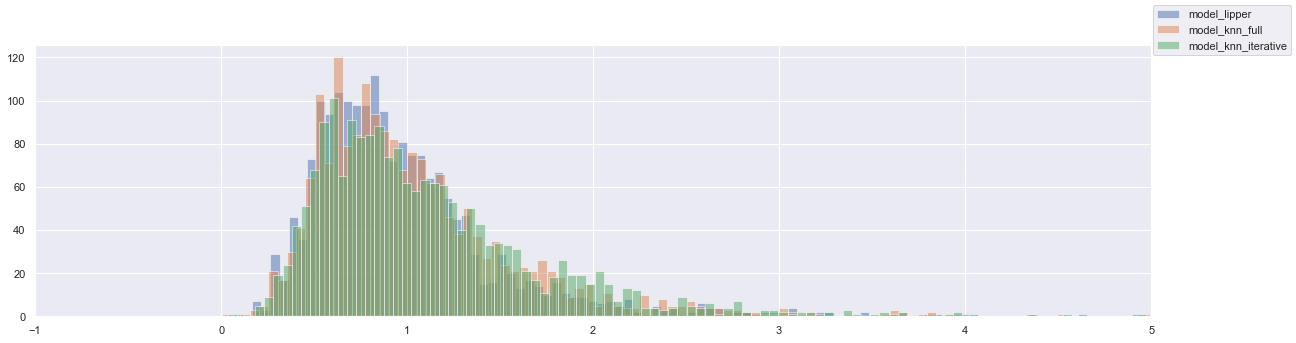

In [212]:
fig, ax = plt.subplots(figsize=(20,5))
for i, col in enumerate(cols):
    ax = error_vol.query(''' model == @col and error < 5''')['error'].hist(label = col,bins = 100, alpha = 0.5)

ax.set_xlim(-1,5)    
fig.legend()
plt.show()

## Sanity checks

### Analysing individual portfolios

In [86]:
comparing_df.query('''true == 'V' and iterative_5 == 'G' ''').head()

NameError: name 'comparing_df' is not defined

In [ ]:
crsp_fundno = 18307
most_common_stocks_fund(year=2017, crsp_fundno=crsp_fundno)

In [ ]:
def most_common_stocks_fund(crsp_fundno,row_info,year):
    "This prints a passed string into this function"
    # Enter date for which most common holdings are calculated
    year = year
    crsp_fundno = crsp_fundno
    row_info_l = row_info

    holdings_coo = holdings.tocoo()

    df_sparse = pd.DataFrame({'row'  : holdings_coo.row,
                              'col'  : holdings_coo.col,
                              'data' : holdings_coo.data})

    df_sparse = df_sparse.merge(row_info_l[['year','row','crsp_fundno']],how='left',on='row')
    my_filter = '''year == @year and crsp_fundno == @crsp_fundno '''
    no_unique_funds = row_info_l.query(my_filter).shape[0]

    sum_col = (df_sparse
               .query(my_filter)
               .groupby(by = ['col'])
               .mean()
               .sort_values('data',ascending = False)
               .join(col_info[['security_name','col']],how='left')
               .assign(percent = lambda x:  x.data)
               .drop(columns=['row','data','col','year','crsp_fundno'])
               .reset_index(drop=True)
               .head(10))
    
    print(
        'Average of most held stocks for one fund in one year: ','\n\n'
        '{}'.format(row_info.query('crsp_fundno == @crsp_fundno').iloc[0,2]),'\n\n'
        'crsp_fundno:                            {}'.format(crsp_fundno),'\n'
        'Number of observations in that year:    {}'.format(no_unique_funds))

    return sum_col

### Inspecting individual nearest neighbors

In [ ]:
neigh.kneighbors(X[1234],n_neighbors = n_neighbors)

In [ ]:
def name_nearestneighbors(row_info,neigh,i,n_neighbors = 5):
    print('Name:')
    print(row_info.loc[i].fund_name)
    print(row_info.loc[i].crsp_fundno)
    print('\nNearest Neighbors:')
    nn_index = neigh.kneighbors(X[i],n_neighbors = n_neighbors)[1].flatten()
    nn_names = row_info.loc[nn_index].fund_name.values
    nn_fundno = row_info.loc[nn_index].crsp_fundno.values
    
    for name in nn_names[1:]:
        print(name)

In [ ]:
name_nearestneighbors(row_info,neigh,i = 1234, n_neighbors = 5)

In [ ]:
crsp_fundno = 36608
most_common_stocks_fund(crsp_fundno=crsp_fundno)

In [ ]:
crsp_fundno = 3690
most_common_stocks_fund(crsp_fundno=crsp_fundno)